# Plot cell-type and disease-specific design

## Read evolution run

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import anndata
from tqdm import tqdm
import torch
import importlib
from lightning import LightningModel

%matplotlib inline
import os
from grelu.visualize import plot_distribution, plot_attributions

In [2]:
buffer = 50

savefile = 'Crohns_fibroblast_design'

mutationF_1 = pd.read_csv(savefile + '_part1.csv')
mutationF_1 = mutationF_1.head(buffer) # only first 50 rounds

mutationF_2 = pd.read_csv(savefile + '_part2.csv')
mutationF_2 = mutationF_2.head(buffer)
mutationF_2['Round'] = mutationF_2['Round'] + buffer

mutationF = pd.concat([mutationF_1, mutationF_2])
mutationF = mutationF.reset_index(drop=True)

# Read model

In [5]:
EBFP_seq = 'ATGGCTAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACACTAGTGACCACCCTGTCCCACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTCGAGTACAACTTCAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGCCAACTTCAAGATCCGCCACAATATTGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGCATCACTCACGGCATGGACGAGCTGTACAAG'
import sys
sys.path.append('/home/gunsalul/tools/decima/src/decima/')

In [ ]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823/"
matrix_file = os.path.join(save_dir, "aggregated.h5ad")
h5_file = os.path.join(save_dir, "data.h5")
ckpt_dir = os.path.join(save_dir, 'lightning_logs')
ckpts = [os.path.join(ckpt_dir, '0as9e8of/checkpoints/epoch=7-step=5840.ckpt'),  ]
model = LightningModel.load_from_checkpoint(ckpts[0]) 
device = 'cuda:1'
model = model.to(device)
model = model.eval()

In [13]:
from grelu.sequence.format import *

window_size = 524288
TSS_offset = 5120*32
# chr22:29,480,218-29,491,390 NEFH
chrom = 'chr22'
TSS_start = 29480218
sequence_start_location = TSS_start - TSS_offset
sequence_end_location = sequence_start_location + window_size
seqF = pd.DataFrame([chrom, sequence_start_location,sequence_end_location]).T
seqF.columns = ['chrom', 'start', 'end']
full_sequence = intervals_to_strings(seqF,genome="hg38")[0]
TSS_drop_location = 67503862
device = model.device
device

device(type='cuda', index=1)

In [23]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[:, ad.var.dataset=="test"]

In [15]:
def place_sequence(full_seq: str, placed_seq: str, loc: int) -> str:
    """
    Place a sequence at a specific location within another sequence.

    Args:
        full_seq (str): The full sequence to insert into.
        placed_seq (str): The sequence to be inserted.
        loc (int): The location to insert the sequence.

    Returns:
        str: The resulting sequence after insertion.
    """
    left_of_start = full_seq[0:loc]
    right_of_start = full_seq[loc:len(full_seq) - len(placed_seq)]
    new_seq = left_of_start + placed_seq + right_of_start
    return new_seq

def make_pred(full_inserted_sequence, inserted_sequence, window_size = 524288, TSS_offset=163840): # element + EBFP
    shape = (window_size)
    arr = np.zeros(shape=shape)
    for i, row in enumerate(ad.var.itertuples()):
        arr[TSS_offset:TSS_offset + len(inserted_sequence)] = 1
    full_seq_one_hot = strings_to_one_hot(full_inserted_sequence, add_batch_axis=False)
    arr_reshaped = torch.tensor(arr.reshape(1, -1))
    x = torch.cat((full_seq_one_hot, arr_reshaped), dim=0).float()
    x = x.to(model.device)
    with torch.no_grad():
        preds = model.forward(x).detach().cpu().numpy()
    preds = preds.squeeze()
    return preds 

In [16]:
taskF = pd.DataFrame(model.data_params['tasks'])

## Define tasks

In [17]:
study = "17481d16-ee44-49e5-bcf0-28c0780d8c4a"
cell_type = "fibroblast"
disease_state = "Crohn's disease"
healthy_state = "healthy"
save_file = 'Crohns_fibroblast_design'
exclude_strings = []

In [18]:
def get_cell_types(df, study, disease):
    return set(df[(df['study'] == study) & (df['disease'] == disease)]['cell_type'])

def label_tasks(row, study, cell_type, disease_state, healthy_state, exclude_strings):
    exclude_strings_lower = [s.lower() for s in exclude_strings]
    cell_type_lower = row['cell_type'].lower()
    
    if row['study'] == study:
        if row['cell_type'] == cell_type:
            if row['disease'] == disease_state:
                return f'{cell_type}_disease'
            elif row['disease'] == healthy_state:
                return f'{cell_type}_healthy'
        else:
            if any(exclude in cell_type_lower for exclude in exclude_strings_lower):
                return 'excluded'
            if row['disease'] == disease_state:
                return f'non_{cell_type}_disease'
            elif row['disease'] == healthy_state:
                return f'non_{cell_type}_healthy'
    return 'excluded'

def label_cell_type(row, study, cell_type, exclude_strings):
    exclude_strings_lower = [s.lower() for s in exclude_strings]
    cell_type_lower = row['cell_type'].lower()
    
    if row['study'] == study:
        if row['cell_type'] == cell_type:
            return cell_type
        elif any(exclude in cell_type_lower for exclude in exclude_strings_lower):
            return 'excluded'
        else:
            return f'non_{cell_type}'
    return 'excluded'

# Assuming taskF is your DataFrame
disease_cell_types = get_cell_types(taskF, study, disease_state)
healthy_cell_types = get_cell_types(taskF, study, healthy_state)
allowed_cell_types = disease_cell_types.union(healthy_cell_types)

# Apply the labeling functions to create new columns
taskF['label'] = taskF.apply(label_tasks, axis=1, args=(study, cell_type, disease_state, healthy_state, exclude_strings))
taskF['cell_type_label'] = taskF.apply(label_cell_type, axis=1, args=(study, cell_type, exclude_strings))

# Define the labels based on the parameters
cell_type_disease_label = f'{cell_type}_disease'
cell_type_healthy_label = f'{cell_type}_healthy'
non_cell_type_disease_label = f'non_{cell_type}_disease'
non_cell_type_healthy_label = f'non_{cell_type}_healthy'
cell_type_label = cell_type
non_cell_type_label = f'non_{cell_type}'

# Filter the DataFrame based on these labels
cell_typeF = taskF[taskF['cell_type_label'] == cell_type]
non_cell_typeF = taskF[(taskF['cell_type_label'] == 'non_' + cell_type) & (taskF['cell_type_label'] != 'excluded')]

cell_type_disease = taskF[taskF['label'] == cell_type + '_disease']
cell_type_healthy = taskF[taskF['label'] == cell_type + '_healthy']

# Re-score mutations

In [21]:
mutationF.shape

(100, 5)

In [24]:
tasks = []
for i,row in mutationF.iterrows():
    print(row['Round'])
    cur_taskF = taskF.copy()
    seq = row['Current_Sequence']
    full_inserted_sequence = place_sequence(full_sequence, seq + EBFP_seq , TSS_offset)
    preds = make_pred(full_inserted_sequence, seq + EBFP_seq)
    cur_taskF['preds'] = preds
    cur_taskF['round'] = row['Round']
    tasks.append(cur_taskF)
    
concat_tasks = [taskF] + tasks # ADD round 0

all_tasks = pd.concat(concat_tasks)
subF = all_tasks[all_tasks['label'] != 'excluded']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


# Re-score mutations

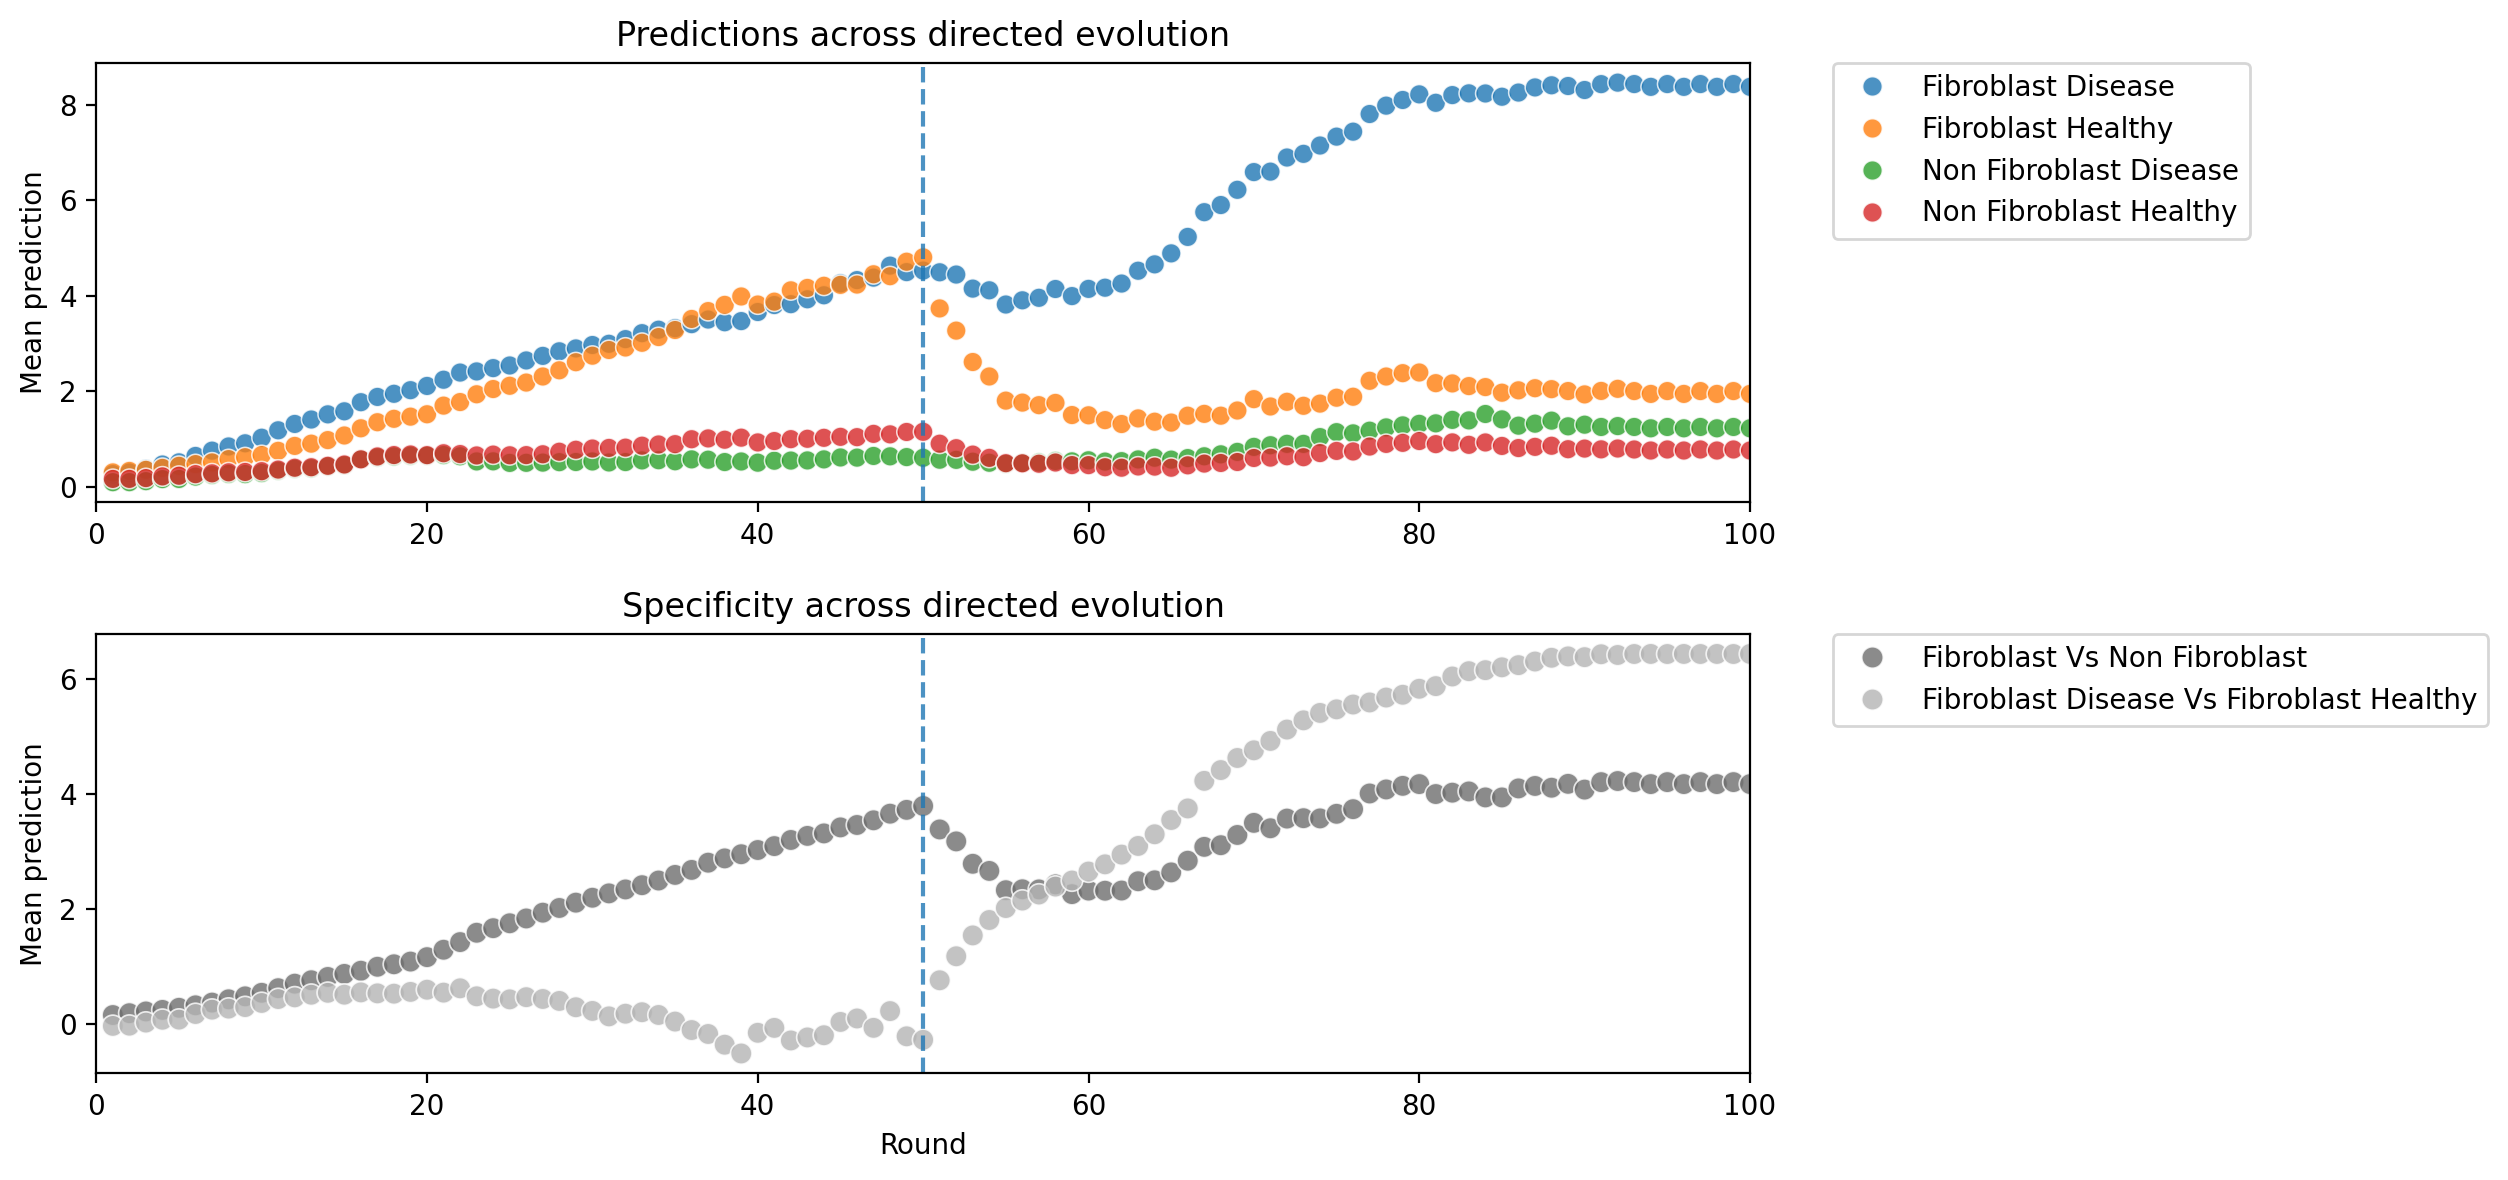

In [52]:
# Assuming all_tasks DataFrame is already created

# Get unique labels and cell_type_labels
unique_labels = all_tasks['label'].unique()
unique_cell_type_labels = all_tasks['cell_type_label'].unique()

# Create dynamic label mapping
label_mapping = {label: label.replace('_', ' ').title() for label in unique_labels if label != 'excluded'}

# First subplot
subF = all_tasks[all_tasks['label'] != 'excluded']
mean_data = subF.groupby(['round', 'label'])['preds'].mean().reset_index()
# Apply the mapping to the dataframes
mean_data['label'] = mean_data['label'].map(label_mapping)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6), dpi=200)

sns.scatterplot(data=mean_data, x='round', y='preds', hue='label', s=50, alpha=.8, ax=ax1)
ax1.set_title('Predictions across directed evolution')
ax1.set_ylabel('Mean prediction')
ax1.set_xlabel('')  # Remove x-label from top subplot
ax1.set_xlim(0, 100)
ax1.axvline(x=50, linestyle='dashed', alpha=.8)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Second subplot
groups = []
for cell_type_label in unique_cell_type_labels:
    if cell_type_label == 'excluded' or 'non_' in cell_type_label:
        continue
    
    non_cell_type_label = f'non_{cell_type_label}'
    cell_type_data = all_tasks[all_tasks['cell_type_label'] == cell_type_label]
    non_cell_type_data = all_tasks[all_tasks['cell_type_label'] == non_cell_type_label]

    cell_type_mean = cell_type_data.groupby('round')['preds'].mean()
    non_cell_type_mean = non_cell_type_data.groupby('round')['preds'].mean()

    diff_cell_type_non_cell_type = (cell_type_mean - non_cell_type_mean).reset_index()
    diff_cell_type_non_cell_type['group'] = f'{cell_type_label.replace("_", " ").title()} vs {non_cell_type_label.replace("_", " ").title()}'
    groups.append(diff_cell_type_non_cell_type)

    # Disease vs Healthy for specific cell type
    if f'{cell_type_label}_disease' in unique_labels and f'{cell_type_label}_healthy' in unique_labels:
        cell_type_disease_data = all_tasks[all_tasks['label'] == f'{cell_type_label}_disease']
        cell_type_healthy_data = all_tasks[all_tasks['label'] == f'{cell_type_label}_healthy']

        cell_type_disease_mean = cell_type_disease_data.groupby('round')['preds'].mean()
        cell_type_healthy_mean = cell_type_healthy_data.groupby('round')['preds'].mean()

        diff_disease_healthy = (cell_type_disease_mean - cell_type_healthy_mean).reset_index()
        diff_disease_healthy['group'] = f'{cell_type_label.replace("_", " ").title()} Disease vs {cell_type_label.replace("_", " ").title()} Healthy'
        groups.append(diff_disease_healthy)

combined_diff = pd.concat(groups).reset_index(drop=True)
combined_diff['group'] = combined_diff['group'].map(lambda x: x.replace('_', ' ').title())

# Define custom shades of grey for the palette
custom_palette = ["#6e6e6e", "#b5b5b5"]

sns.scatterplot(data=combined_diff, x='round', y='preds', hue='group', s=60, alpha=.8,
                palette=custom_palette, ax=ax2)
plt.axvline(x=50, linestyle='dashed', alpha=.8)
ax2.set_title('Specificity across directed evolution')
ax2.set_xlabel('Round')
ax2.set_ylabel('Mean prediction')
ax2.set_xlim(0, 100)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.8, hspace=0.3)

plt.show()


In [185]:
final_round = 100.0
final_round = mean_data[mean_data['round'] == final_round]

In [186]:
final_round

,round,label,preds
396,100.0,Fibroblast Disease,8.378725
397,100.0,Fibroblast Healthy,1.945227
398,100.0,Non Fibroblast Disease,1.224923
399,100.0,Non Fibroblast Healthy,0.759373


In [188]:
final_round[final_round['label'] == 'Fibroblast Disease']['preds'].item() / final_round[final_round['label'] == 'Non Fibroblast Disease']['preds'].item()

6.840204095197842

In [189]:
final_round[final_round['label'] == 'Fibroblast Disease']['preds'].item() / final_round[final_round['label'] == 'Fibroblast Healthy']['preds'].item()

4.307325816607982

# ISM across groups

In [26]:
def ism(full_inserted_sequence, inserted_sequence, make_pred_func):
    """
    Perform In Silico Mutagenesis (ISM) on the given sequence.
    
    :param full_inserted_sequence: The full sequence including the inserted sequence
    :param inserted_sequence: The sequence to mutate (subset of full_inserted_sequence)
    :param make_pred_func: Function that takes (full_inserted_sequence, inserted_sequence) and returns predictions
    :return: 3D numpy array of shape (4, len(inserted_sequence), 8745)
    """
    bases = ['A', 'T', 'G', 'C']
    n_bases = len(bases)
    seq_length = len(inserted_sequence)
    n_celltypes = taskF.shape[0]
    
    # Initialize the ISM matrix
    ism_matrix = np.zeros((n_bases, seq_length, n_celltypes))
    
    # Get predictions for the original sequence
    original_preds = make_pred_func(full_inserted_sequence, inserted_sequence)
    
    # Find the start index of inserted_sequence within full_inserted_sequence
    start_index = full_inserted_sequence.index(inserted_sequence)
    
    # Iterate over each position in the inserted sequence
    for pos in tqdm(range(seq_length), desc="Positions"):
        original_base = inserted_sequence[pos]
        
        # Iterate over each possible base substitution
        for i, base in enumerate(bases):
            if base == original_base:
                continue  # Skip if it's the same as the original base
            
            # Create mutated full sequence
            mutated_full_seq = (full_inserted_sequence[:start_index + pos] + 
                                base + 
                                full_inserted_sequence[start_index + pos + 1:])
            
            # Create mutated inserted sequence
            mutated_inserted_seq = inserted_sequence[:pos] + base + inserted_sequence[pos+1:]
            
            # Get predictions for the mutated sequence
            mutated_preds = make_pred_func(mutated_full_seq, mutated_inserted_seq)
            
            # Calculate change in predictions for each cell type
            ism_matrix[i, pos, :] = mutated_preds - original_preds
    
    return ism_matrix


In [77]:
final_round = 100

In [78]:
final_sequence = mutationF[mutationF['Round'] == final_round].Current_Sequence.item()
final_sequence

'ATGATTGAGCAAGGTGGGGAACATTCCCGTCATCCCTCGAGGTTTATGACGCGAGTTCCAGGAAACTTTCCAAAACTTTTTCTTGGCAAGCCCCCGCTCAGCCTCCCTTGTGACGCACTCTGCGTTCTTTTATAGACATCTTTATAGGGTAGAGACGCCAGAGTCAGGGTCAGTTCGGACAGCGCTCTGAGTAGCGCCAT'

In [62]:
placed_seq = place_sequence(full_sequence, final_sequence + EBFP_seq, TSS_offset)

In [63]:
ism_results = ism(placed_seq, final_sequence, make_pred)

Positions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:53<00:00,  1.17s/it]


In [64]:
np.save('fibroblast_crohns_evolve_nov20.npy', ism_results)

### Halfway ISM

In [84]:
half_round = 49
halfway_sequence = mutationF[mutationF['Round'] == half_round].Current_Sequence.item()
placed_halfway_seq = place_sequence(full_sequence, halfway_sequence + EBFP_seq, TSS_offset)
halfway_ism_results = ism(placed_halfway_seq, halfway_sequence, make_pred)

np.save('fibroblast_crohns_evolve_partial_nov20.npy',halfway_ism_results)

Positions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:54<00:00,  1.17s/it]


In [ ]:
def plot_ism_heatmap(ism_results, sequence, title="ISM Heatmap for AD Brain Tasks"):
    """
    Plot a heatmap of the mean ISM results across AD brain tasks.
    
    :param ism_results: numpy array of shape (4, sequence_length) containing mean ISM results
    :param sequence: original DNA sequence
    :param title: title for the plot
    """
    bases = ['A', 'T', 'G', 'C']
    
    plt.figure(figsize=(20, 6))
    sns.heatmap(ism_results, cmap='RdBu_r', center=0, 
                xticklabels=list(sequence), yticklabels=bases)
    
    plt.title(title)
    plt.xlabel("Sequence Position")
    plt.ylabel("Mutated Base")
    
    # Add colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Mean Change in Prediction', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()


In [33]:
fibroblast_disease = taskF[taskF['label'] == 'fibroblast_disease']
fibroblast_healthy = taskF[taskF['label'] == 'fibroblast_healthy']
non_fibroblast_disease = taskF[taskF['label'] == 'non_fibroblast_disease']
non_fibroblast_healthy = taskF[taskF['label'] == 'non_fibroblast_healthy']

In [68]:
cell_typeF  = taskF[taskF['cell_type_label'] == cell_type]
non_cell_typeF = taskF[taskF['cell_type_label'] == 'non_' + cell_type]

cell_type_disease = taskF[taskF['label'] == cell_type + '_disease']
cell_type_healthy = taskF[taskF['label'] == cell_type + '_healthy']

In [69]:
non_cell_type_disease = taskF[taskF['label'] == 'non_' + cell_type + '_disease']
non_cell_type_healthy = taskF[taskF['label'] == 'non_' + cell_type + '_healthy']

In [72]:
sequence = final_sequence

# Final sequence ISM results

In [74]:
mutationF['relative_pos'] = mutationF['Position'] - TSS_offset

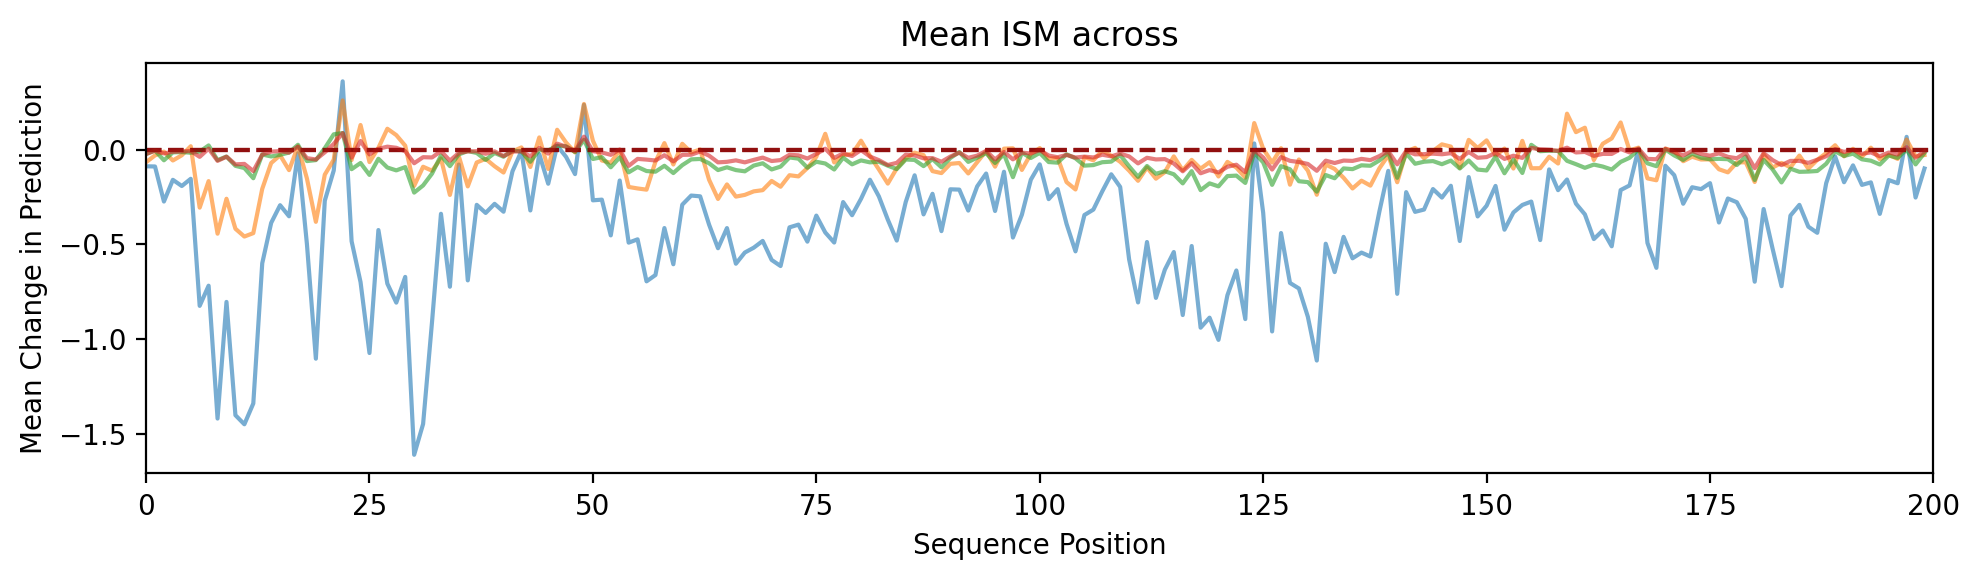

In [177]:
task_list = [             cell_type_disease.index.values, 
             cell_type_healthy.index.values,
    non_cell_type_disease.index.values, 
             non_cell_type_healthy.index.values,
 ] 
mean_ism_results = [ism_results[:, :, cur_task].mean(axis=2) for cur_task in task_list]
mean_results_line = [mean_result.mean(axis=0) for mean_result in mean_ism_results]

plt.figure(figsize=(10, 3), dpi=200)
for i in range(len(task_list)):
    plt.plot(range(len(sequence)), mean_results_line[i], alpha=.6)
    plt.xlabel("Sequence Position")
    plt.ylabel("Mean Change in Prediction")
    plt.xlim(0,len(sequence))
    plt.axhline(y=0, color='darkred', linestyle='--', alpha=0.5)
    #plt.legend()
    plt.tight_layout()
    plt.title(f'Mean ISM across')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Scan for motifs in final evolved sequence

In [90]:
from grelu.interpret.motifs import scan_sequences
import grelu.interpret.motifs

In [91]:
scanF = scan_sequences(
        seqs=[halfway_sequence, sequence],
        motifs = "/gstore/data/resbioai/gunsalul/annotations/H12CORE_jaspar_format.meme", # HOCOMOCOv12
        names=None,
        seq_ids=['round1', 'round2'],
        rc=True, 
    )

Read 1443 motifs from file.


In [92]:
scanF

,motif,sequence,start,end,strand,score,pval
0,ALX1.H12CORE.0.SM.B,round2,29,10,-,5.480769,0.000523
1,ALX1.H12CORE.0.SM.B,round2,18,37,+,4.576923,0.000722
2,ALX3.H12CORE.0.SM.B,round2,17,28,+,7.346154,0.000588
3,ALX3.H12CORE.0.SM.B,round2,22,11,-,6.538462,0.000766
4,ALX3.H12CORE.1.S.B,round2,30,11,-,8.451613,0.000192
...,...,...,...,...,...,...,...
1779,ZSC22.H12CORE.0.P.C,round1,180,196,+,4.922222,0.000634
1780,ZSC22.H12CORE.0.P.C,round1,102,86,-,4.277778,0.000820
1781,ZSC29.H12CORE.1.M.C,round1,16,35,+,-1.409091,0.000871
1782,ZSC31.H12CORE.1.SM.B,round2,115,96,-,-0.103448,0.000485


In [93]:
def calculate_ism_weight(row: pd.Series, ism: np.ndarray) -> float:
    max_ism = np.abs(ism).max(axis=0)
    start, end = min(row["start"], row["end"]), max(row["start"], row["end"])
    return max_ism[start:end].mean()

In [94]:
scanF['motif_center'] = scanF.apply(lambda row: min(row['end'], row['start']) + abs(row['end'] - row['start']) // 2, axis=1)
halfway_disease_ism_track = halfway_ism_results[:,:,cell_type_disease.index.values].mean(axis=2)
full_disease_ism_track = ism_results[:,:,cell_type_disease.index.values].mean(axis=2)
scanF['halfway_ism_weight'] = scanF.apply(calculate_ism_weight, ism=halfway_disease_ism_track, axis=1)
scanF['full_ism_weight'] = scanF.apply(calculate_ism_weight, ism=full_disease_ism_track, axis=1)


In [95]:
scanF_round1 = scanF[scanF['sequence'] == 'round1']
scanF_round2 = scanF[scanF['sequence'] == 'round2']

In [155]:
test_start = 130
test_end = 150

In [156]:
print(halfway_sequence[test_start:test_end])
print(sequence[test_start:test_end])

TAAAGTAAGTTTTTTGGGGG
TAAAGTTAACTCCTTGGGAG


In [157]:
scanF_r1 = scanF[scanF['sequence'] == 'round1']
scanF_r1[(scanF_r1['motif_center'] <= test_end) & (scanF_r1['motif_center'] >= test_start)].sort_values(by='halfway_ism_weight', ascending=False).head(10)

,motif,sequence,start,end,strand,score,pval,motif_center,halfway_ism_weight,full_ism_weight
729,MYT1L.H12CORE.0.P.C,round1,135,142,+,7.887097,0.000914,138,0.548263,0.920697
90,BARX1.H12CORE.0.P.C,round1,134,144,+,7.025974,0.000931,139,0.509044,0.843947
547,KLF10.H12CORE.1.PSM.A,round1,133,156,+,-8.461538,0.000542,144,0.397147,0.735110
1646,ZN701.H12CORE.0.P.B,round1,135,153,+,4.542857,0.000480,144,0.395909,0.748206
1493,ZN316.H12CORE.0.P.C,round1,154,131,-,5.082569,0.000138,142,0.391297,0.828601
1372,Z354A.H12CORE.0.P.B,round1,120,142,+,0.236364,0.000600,131,0.388311,1.095861
1401,ZFP28.H12CORE.0.P.B,round1,120,142,+,2.071429,0.000756,131,0.388311,1.095861
1448,ZN160.H12CORE.0.P.C,round1,143,119,-,-1.243243,0.000473,131,0.383291,1.093044
1606,ZN570.H12CORE.0.P.C,round1,145,127,-,-0.986842,0.000847,136,0.372779,1.003151
1616,ZN613.H12CORE.0.P.C,round1,120,144,+,5.944444,0.000810,132,0.370903,1.060847


In [158]:
scanF_r2 = scanF[scanF['sequence'] == 'round2']
scanF_r2[(scanF_r2['motif_center'] <= test_end) & (scanF_r2['motif_center'] >= test_start)].sort_values(by='pval', ascending=True).head(30)

,motif,sequence,start,end,strand,score,pval,motif_center,halfway_ism_weight,full_ism_weight
1620,ZN652.H12CORE.0.PS.A,round2,146,136,-,13.838710,0.000012,141,0.366685,0.751409
1275,THB.H12CORE.3.S.C,round2,142,121,-,11.292308,0.000015,131,0.380980,1.079080
383,GLIS1.H12CORE.1.P.B,round2,142,152,+,12.727273,0.000020,147,0.289319,0.583743
395,GLIS3.H12CORE.0.P.C,round2,142,154,+,12.163265,0.000029,148,0.289644,0.624316
1179,TBP.H12CORE.0.P.B,round2,135,126,-,11.871287,0.000039,130,0.286238,1.288366
388,GLIS1.H12CORE.2.SM.B,round2,137,155,+,6.019231,0.000055,146,0.325039,0.701773
1544,ZN460.H12CORE.0.S.C,round2,144,156,+,11.000000,0.000064,150,0.312615,0.605417
380,GLIS1.H12CORE.0.P.B,round2,140,153,+,10.382022,0.000094,146,0.264958,0.704569
1554,ZN468.H12CORE.0.P.C,round2,144,156,+,7.064516,0.000105,150,0.312615,0.605417
1160,SRF.H12CORE.0.PSM.A,round2,123,139,+,9.442623,0.000106,131,0.410039,1.101701


In [159]:
scanF_r2 = scanF[scanF['sequence'] == 'round2']
scanF_r2[(scanF_r2['motif_center'] <= test_end) & (scanF_r2['motif_center'] >= test_start)].sort_values(by='full_ism_weight', ascending=False).head(30)

,motif,sequence,start,end,strand,score,pval,motif_center,halfway_ism_weight,full_ism_weight
1179,TBP.H12CORE.0.P.B,round2,135,126,-,11.871287,0.000039,130,0.286238,1.288366
477,HXD13.H12CORE.1.SM.B,round2,136,126,-,6.288462,0.000729,131,0.353717,1.276416
476,HXD13.H12CORE.0.PS.A,round2,136,126,-,8.900990,0.000376,131,0.353717,1.276416
15,ARI1A.H12CORE.0.P.C,round2,135,125,-,6.574257,0.000935,130,0.277395,1.216356
472,HXC13.H12CORE.0.SM.B,round2,136,125,-,3.903846,0.000838,130,0.339544,1.212039
463,HXB13.H12CORE.1.SM.B,round2,136,125,-,3.557692,0.000819,130,0.339544,1.212039
461,HXB13.H12CORE.0.PS.A,round2,136,125,-,7.555556,0.000529,130,0.339544,1.212039
456,HXA13.H12CORE.1.SM.B,round2,136,125,-,4.519231,0.000883,130,0.339544,1.212039
455,HXA13.H12CORE.0.P.B,round2,136,127,-,5.209677,0.000738,131,0.359838,1.211090
1622,ZN652.H12CORE.0.PS.A,round2,129,139,+,6.564516,0.000458,134,0.512435,1.156732


In [164]:
scanF_r1.sort_values(by='pval', ascending=True).head(30)

,motif,sequence,start,end,strand,score,pval,motif_center,halfway_ism_weight,full_ism_weight
415,HAND2.H12CORE.0.P.B,round1,5,22,+,17.258065,1.817479e-07,13,0.708402,1.194292
345,FOXG1.H12CORE.0.PSM.A,round1,77,91,+,14.387097,6.420173e-07,84,0.165501,0.568719
1696,ZN770.H12CORE.1.P.B,round1,106,85,-,16.479592,1.171137e-06,95,0.176975,0.572138
1286,TWST1.H12CORE.1.P.B,round1,2,17,+,15.258065,1.663585e-06,9,0.727447,1.206636
1543,ZN460.H12CORE.0.S.C,round1,144,156,+,15.218182,3.938013e-06,150,0.312615,0.605417
1149,SRBP1.H12CORE.0.P.B,round1,110,121,+,15.016129,4.265548e-06,115,0.519901,1.207570
213,CREM.H12CORE.0.PSM.A,round1,109,118,+,13.461538,4.868612e-06,113,0.508893,1.069873
86,BACH2.H12CORE.1.SM.B,round1,157,173,+,13.961538,5.241099e-06,165,0.300947,0.605491
414,HAND1.H12CORE.0.P.B,round1,6,22,+,14.155963,5.963832e-06,14,0.731730,1.252084
1642,ZN701.H12CORE.0.P.B,round1,109,91,-,13.628571,7.040129e-06,100,0.207818,0.562324


In [165]:
scanF_r2.sort_values(by='pval', ascending=True).head(30)

,motif,sequence,start,end,strand,score,pval,motif_center,halfway_ism_weight,full_ism_weight
1280,TWST1.H12CORE.0.P.B,round2,6,23,+,16.893939,0.000001,14,0.694777,1.210152
482,IRF2.H12CORE.0.PSM.A,round2,175,191,+,15.919355,0.000002,183,0.336310,0.801725
927,PAX4.H12CORE.1.S.C,round2,10,25,+,15.910448,0.000003,17,0.579791,1.041119
433,HNF4A.H12CORE.0.PSM.A,round2,129,115,-,15.477064,0.000003,122,0.361132,1.129276
437,HNF4G.H12CORE.0.P.B,round2,130,116,-,15.193548,0.000004,123,0.344782,1.130478
1715,ZN821.H12CORE.0.SM.B,round2,38,54,+,13.344828,0.000004,46,0.255631,0.461354
1758,ZNF41.H12CORE.1.P.C,round2,113,99,-,13.881818,0.000006,106,0.323147,0.658881
1678,ZN75A.H12CORE.0.SM.B,round2,76,62,-,14.337079,0.000007,69,0.290185,0.833772
1287,TWST1.H12CORE.1.P.B,round2,2,17,+,13.838710,0.000008,9,0.727447,1.206636
996,PRDM1.H12CORE.0.S.B,round2,180,191,+,14.137931,0.000009,185,0.393251,0.865608


In [425]:
mutationF['relative_pos'] = mutationF['Position'] - TSS_offset

In [426]:
mutationF

,Round,Position,Base,Specificity,Current_Sequence,relative_pos
0,1,163916,C,0.001350,GTAGGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...,76
1,2,163874,A,0.002443,GTAGGTAAGCGGGGTATTTGCACTTCCCTTAATCAATAAGGGCTTT...,34
2,3,163859,T,0.012787,GTAGGTAAGCGGGGTATTTTCACTTCCCTTAATCAATAAGGGCTTT...,19
3,4,163856,G,0.023502,GTAGGTAAGCGGGGTAGTTTCACTTCCCTTAATCAATAAGGGCTTT...,16
4,5,163872,A,0.036181,GTAGGTAAGCGGGGTAGTTTCACTTCCCTTAAACAATAAGGGCTTT...,32
...,...,...,...,...,...,...
45,96,164034,C,2.684279,GATGTTTGCACAGGTGTTTGCACTTACTTCAAACAAAGGGGGCTCT...,194
46,97,163895,A,2.699183,GATGTTTGCACAGGTGTTTGCACTTACTTCAAACAAAGGGGGCTCT...,55
47,98,164026,A,2.705473,GATGTTTGCACAGGTGTTTGCACTTACTTCAAACAAAGGGGGCTCT...,186
48,99,163848,A,2.724444,GATGTTTGAACAGGTGTTTGCACTTACTTCAAACAAAGGGGGCTCT...,8


In [ ]:
scanF['motif_center'] = scan.apply(lambda row: min(row['end'], row['start']) + abs(row['end'] - row['start']) // 2, axis=1)
scanF_halfway_disease = scan_halfway.copy()
scanF_halfway_healthy = scan_halfway.copy()

disease_ism_track = halfway_ism_results[:,:,fibroblast_disease.index.values].mean(axis=2)
healthy_ism_track = halfway_ism_results[:,:,non_fibroblast_healthy.index.values].mean(axis=2)

scanF_halfway_disease['ism_weight'] = scan.apply(calculate_ism_weight, ism=disease_ism_track, axis=1)
scanF_halfway_healthy['ism_weight'] = scan.apply(calculate_ism_weight, ism=healthy_ism_track, axis=1)

In [309]:
scan_halfway['motif_center'] = scan.apply(lambda row: min(row['end'], row['start']) + abs(row['end'] - row['start']) // 2, axis=1)
scanF_halfway_disease = scan_halfway.copy()
scanF_halfway_healthy = scan_halfway.copy()

disease_ism_track = halfway_ism_results[:,:,fibroblast_disease.index.values].mean(axis=2)
healthy_ism_track = halfway_ism_results[:,:,non_fibroblast_healthy.index.values].mean(axis=2)

scanF_halfway_disease['ism_weight'] = scan.apply(calculate_ism_weight, ism=disease_ism_track, axis=1)
scanF_halfway_healthy['ism_weight'] = scan.apply(calculate_ism_weight, ism=healthy_ism_track, axis=1)

In [332]:
scanF_halfway_disease.sort_values(by='ism_weight', ascending=False).head(40)

,motif,sequence,start,end,strand,score,pval,motif_center,ism_weight
648,TAF1.H12CORE.0.P.B,fibroblast_evolved,106,92,-,6.367347,8.732008e-04,130.0,1.086647
141,FOXC2.H12CORE.0.SM.B,fibroblast_evolved,76,92,+,8.480769,1.790527e-04,112.0,1.078663
136,FOXA2.H12CORE.0.PSM.A,fibroblast_evolved,37,48,+,7.419355,3.718005e-04,112.0,1.053441
14,BACH1.H12CORE.0.P.B,fibroblast_evolved,157,168,+,2.950820,8.217102e-04,112.0,1.053441
232,KLF1.H12CORE.0.P.B,fibroblast_evolved,5,17,+,8.435484,2.539002e-04,131.0,1.051057
724,WT1.H12CORE.1.P.B,fibroblast_evolved,2,22,+,6.685393,3.080473e-04,111.0,1.035547
245,KLF11.H12CORE.0.P.B,fibroblast_evolved,105,91,-,7.030612,1.404004e-04,131.0,1.019302
246,KLF11.H12CORE.0.P.B,fibroblast_evolved,3,17,+,2.346939,7.954044e-04,131.0,1.019302
139,FOXA3.H12CORE.0.PS.A,fibroblast_evolved,35,46,+,7.661290,4.434252e-04,114.0,1.018888
196,HSFY1.H12CORE.1.S.B,fibroblast_evolved,26,9,-,6.292683,1.914919e-04,114.0,1.018888


In [354]:
scan = scan_sequences(
        seqs=[sequence],
        motifs = "/gstore/data/resbioai/gunsalul/annotations/H12CORE_jaspar_format.meme", # HOCOMOCOv12
        names=None,
        seq_ids=['fibroblast_evolved'],
        #pthresh=0.01,
        rc=True, 
    )

Read 1443 motifs from file.


In [355]:
def calculate_ism_weight(row: pd.Series, ism: np.ndarray) -> float:
    max_ism = np.abs(ism).max(axis=0)
    start, end = min(row["start"], row["end"]), max(row["start"], row["end"])
    return max_ism[start:end].mean()

In [356]:
scan['motif_center'] = scan.apply(lambda row: min(row['end'], row['start']) + abs(row['end'] - row['start']) // 2, axis=1)
scanF_disease = scan.copy()
scanF_healthy = scan.copy()

disease_ism_track = ism_results[:,:,fibroblast_disease.index.values].mean(axis=2)
healthy_ism_track = ism_results[:,:,non_fibroblast_healthy.index.values].mean(axis=2)

scanF_disease['ism_weight'] = scan.apply(calculate_ism_weight, ism=disease_ism_track, axis=1)
scanF_healthy['ism_weight'] = scan.apply(calculate_ism_weight, ism=healthy_ism_track, axis=1)

In [359]:
scanF_disease.sort_values(by='ism_weight', ascending=False).head(60)

,motif,sequence,start,end,strand,score,pval,motif_center,ism_weight
722,ZBT26.H12CORE.0.PSM.A,fibroblast_evolved,76,69,-,8.359551,0.000357,72,1.309534
204,GMEB2.H12CORE.1.P.C,fibroblast_evolved,118,110,-,11.269663,0.000107,114,1.253954
139,FOSB.H12CORE.0.P.B,fibroblast_evolved,118,110,-,8.225806,0.000377,114,1.253954
196,GMEB1.H12CORE.0.P.C,fibroblast_evolved,118,110,-,11.948980,0.000037,114,1.253954
563,SMAD4.H12CORE.0.P.B,fibroblast_evolved,77,70,-,7.377551,0.000905,73,1.245785
226,HSF1.H12CORE.1.P.B,fibroblast_evolved,77,69,-,9.671429,0.000188,73,1.211572
73,CREM.H12CORE.0.PSM.A,fibroblast_evolved,109,118,+,11.653846,0.000101,113,1.166041
11,ATF1.H12CORE.0.P.B,fibroblast_evolved,109,118,+,11.669014,0.000041,113,1.166041
252,JUNB.H12CORE.0.PM.A,fibroblast_evolved,118,109,-,9.629032,0.000150,113,1.166041
17,ATF3.H12CORE.1.P.B,fibroblast_evolved,109,118,+,11.919643,0.000024,113,1.166041


# Logo plots

In [98]:
import grelu.visualize

In [104]:
full_ismF = pd.DataFrame(full_disease_ism_track)
full_ismF.columns = list(sequence)

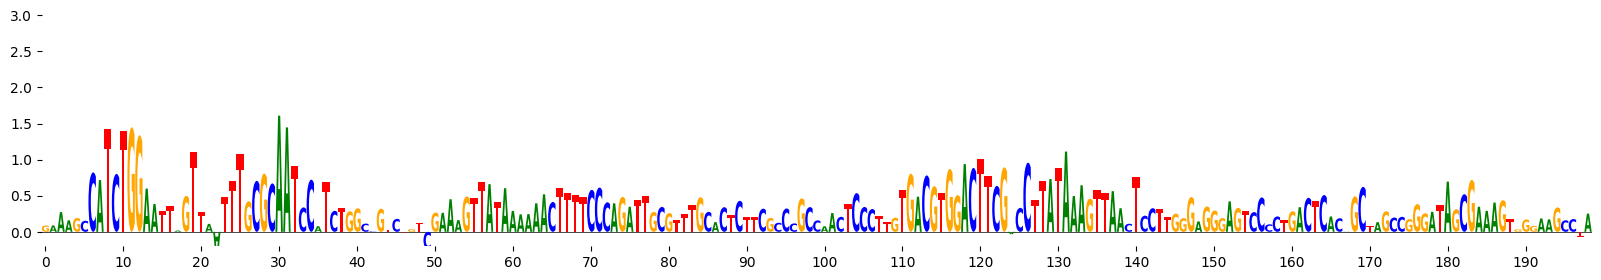

In [171]:
full_ismF = pd.DataFrame(full_disease_ism_track)
full_ismF.columns = list(sequence)
plot_ISM(full_ismF, method="logo", figsize=(20,3),ymax=3, ymin=-.2)  

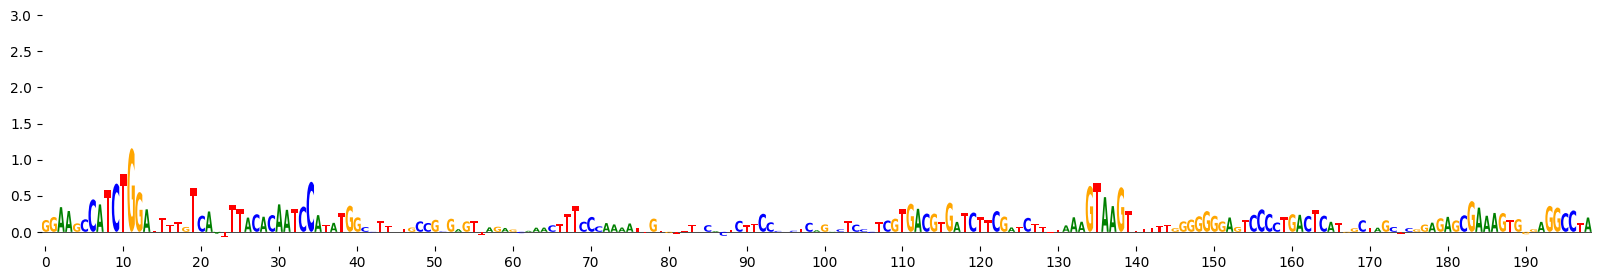

In [173]:
halfway_ismF = pd.DataFrame(halfway_disease_ism_track)
halfway_ismF.columns = list(halfway_sequence)
plot_ISM(halfway_ismF, method="logo", figsize=(20, 3),ymax=3, ymin=-.2)  

# Plot HOMOCOCO motifs

### New Crohn's 

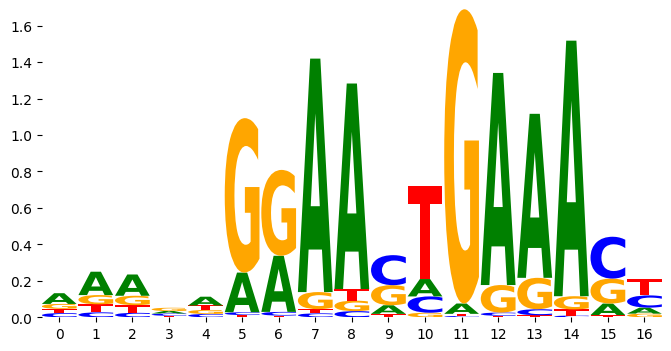

In [75]:
tbd_dict = {
    "A": [132, 67, 841, 25, 922, 685, 959, 830, 279, 135],
    "C": [568, 34, 7, 14, 1, 1, 6, 5, 19, 299],
    "G": [219, 24, 10, 18, 2, 9, 28, 63, 652, 515],
    "T": [78, 872, 139, 940, 72, 302, 4, 99, 47, 48]
}

twst1_h12core_pcm = {
    "A": [383.0, 26.0, 684.0, 3.0, 83.0, 2.0, 1.0, 9.0, 205.0, 173.0, 61.0, 47.0, 303.0, 620.0, 0.0, 58.0, 456.0, 173.0],
    "C": [150.0, 670.0, 3.0, 27.0, 569.0, 0.0, 1.0, 79.0, 81.0, 61.0, 221.0, 266.0, 265.0, 26.0, 22.0, 91.0, 17.0, 80.0],
    "G": [140.0, 7.0, 8.0, 134.0, 48.0, 0.0, 697.0, 418.0, 45.0, 60.0, 81.0, 74.0, 83.0, 40.0, 36.0, 33.0, 28.0, 331.0],
    "T": [31.0, 1.0, 9.0, 540.0, 4.0, 702.0, 5.0, 198.0, 373.0, 410.0, 341.0, 317.0, 53.0, 18.0, 646.0, 522.0, 203.0, 120.0]
}

cebpa_h12core_pcm = {
    "A": [285.0, 426.0, 2.0, 13.0, 337.0, 65.0, 4.0, 60.0, 996.0, 1001.0, 16.0, 402.0],
    "C": [77.0, 105.0, 3.0, 0.0, 5.0, 477.0, 4.0, 912.0, 7.0, 0.0, 258.0, 316.0],
    "G": [353.0, 443.0, 15.0, 264.0, 498.0, 53.0, 979.0, 11.0, 0.0, 2.0, 111.0, 156.0],
    "T": [289.0, 30.0, 984.0, 727.0, 164.0, 409.0, 17.0, 21.0, 1.0, 1.0, 619.0, 130.0]
}

stat3_h12core_pcm = {
    "A": [103.0, 390.0, 117.0, 7.0, 13.0, 140.0, 2.0, 12.0, 236.0, 50.0, 719.0, 887.0, 356.0],
    "C": [456.0, 221.0, 313.0, 8.0, 5.0, 818.0, 820.0, 592.0, 23.0, 30.0, 250.0, 47.0, 176.0],
    "G": [257.0, 241.0, 157.0, 6.0, 31.0, 8.0, 6.0, 0.0, 722.0, 709.0, 6.0, 33.0, 346.0],
    "T": [184.0, 148.0, 413.0, 979.0, 951.0, 34.0, 172.0, 396.0, 19.0, 211.0, 25.0, 33.0, 122.0]
}

cr3l1_h12core_pcm = {
    "A": [2279.25, 1696.50, 2190.00, 2941.00, 981.00, 8989.00, 2.00, 0.00, 2.00, 5.00, 14.00, 429.00, 5390.75, 1829.00],
    "C": [1833.25, 1243.50, 1660.00, 3133.00, 4000.00, 13.00, 9262.00, 0.00, 0.00, 1.00, 77.00, 8529.00, 964.75, 2436.00],
    "G": [2208.25, 4377.50, 3264.00, 825.00, 1904.00, 161.00, 6.00, 9281.00, 0.00, 9277.00, 8817.00, 116.00, 1679.75, 1829.00],
    "T": [2962.25, 1965.50, 2169.00, 2384.00, 2398.00, 120.00, 13.00, 2.00, 9281.00, 0.00, 375.00, 209.00, 1247.75, 3189.00]
}

irf4_h12core_pcm = {
    "A": [439.0, 505.0, 490.0, 257.0, 420.0, 196.0, 375.0, 889.0, 866.0, 137.0, 130.0, 33.0, 855.0, 794.0, 910.0, 141.0, 154.0],
    "C": [171.0, 107.0, 102.0, 236.0, 158.0, 14.0, 25.0, 15.0, 26.0, 476.0, 122.0, 4.0, 13.0, 29.0, 6.0, 512.0, 313.0],
    "G": [201.0, 199.0, 215.0, 338.0, 193.0, 764.0, 574.0, 65.0, 44.0, 318.0, 34.0, 941.0, 111.0, 152.0, 47.0, 305.0, 93.0],
    "T": [174.0, 174.0, 178.0, 154.0, 214.0, 11.0, 11.0, 16.0, 49.0, 54.0, 699.0, 7.0, 6.0, 10.0, 22.0, 27.0, 425.0]
}


jaspar_data = irf4_h12core_pcm
pcm_df = pd.DataFrame(jaspar_data) 

total_counts = pcm_df.sum(axis=1)
pfm_df = pcm_df.div(total_counts, axis=0)
information_content = 2 + np.sum(pfm_df * np.log2(pfm_df.clip(lower=1e-6)), axis=1)
icm_df = pfm_df.multiply(information_content, axis=0)
fig, ax = plt.subplots(figsize=(8,4))
logo = logomaker.Logo(icm_df, ax=ax)
logo.style_spines(visible=False)  # Remove axis spines
logo.style_xticks(anchor=0, spacing=1)  # Position x-ticks appropriately
plt.show()

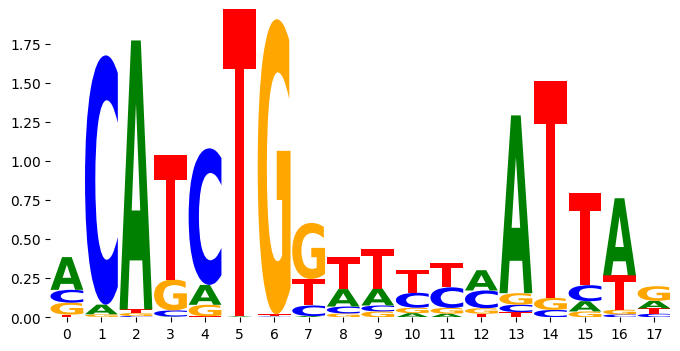

In [76]:
jaspar_data = twst1_h12core_pcm
pcm_df = pd.DataFrame(jaspar_data) 

total_counts = pcm_df.sum(axis=1)
pfm_df = pcm_df.div(total_counts, axis=0)
information_content = 2 + np.sum(pfm_df * np.log2(pfm_df.clip(lower=1e-6)), axis=1)
icm_df = pfm_df.multiply(information_content, axis=0)
fig, ax = plt.subplots(figsize=(8,4))
logo = logomaker.Logo(icm_df, ax=ax)
logo.style_spines(visible=False)  # Remove axis spines
logo.style_xticks(anchor=0, spacing=1)  # Position x-ticks appropriately
plt.show()

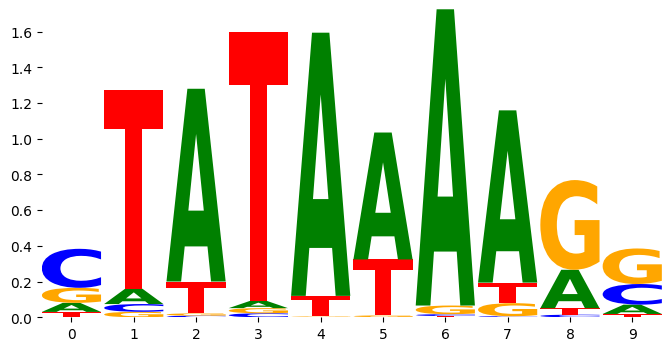

In [237]:
jaspar_data = tbd_dict
pcm_df = pd.DataFrame(jaspar_data) # fosb_dict
total_counts = pcm_df.sum(axis=1)
pfm_df = pcm_df.div(total_counts, axis=0)
information_content = 2 + np.sum(pfm_df * np.log2(pfm_df.clip(lower=1e-6)), axis=1)
icm_df = pfm_df.multiply(information_content, axis=0)
fig, ax = plt.subplots(figsize=(8,4))
logo = logomaker.Logo(icm_df, ax=ax)
logo.style_spines(visible=False)  # Remove axis spines
logo.style_xticks(anchor=0, spacing=1)  # Position x-ticks appropriately
plt.show()
